In [1]:

!pip install scikit-learn-extra
!pip install umap-learn
from umap import UMAP
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


In [2]:
classes = ["food", "Fitness", "hinduism", "travel"]
class_mapping = {'Fitness': 0, 'food': 1, 'hinduism': 2, 'travel': 3}


# Bag of Words

In [3]:
def load_pickle_file(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

y_train_numeric = np.load("y_train.npy")
y_test_numeric = np.load("y_test.npy")

x_train = load_pickle_file("x_train.pkl")
x_test = load_pickle_file("x_test.pkl")


In [11]:
x_train_text = [" ".join(doc) for doc in x_train]
x_test_text = [" ".join(doc) for doc in x_test]

In [19]:
def create_tfidf(texts, ngram_range=(1, 2), min_df=2, max_df=0.85):

    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range,
        stop_words = None
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    return tfidf_matrix, vectorizer

tfidf_train, tfidf_vectorizer = create_tfidf(x_train_text, ngram_range=(1, 2))
tfidf_test = tfidf_vectorizer.transform(x_test_text)


Bag-of-Words matrix shape: (1600, 7916)


In [50]:

def apply_truncated_svd(tfidf_matrix, n_components=300):

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    print(f"Reduced TF-IDF matrix shape: {reduced_matrix.shape}")
    return reduced_matrix, svd

x_train_vectors_tf, svd = apply_truncated_svd(tfidf_train, n_components=150)
x_test_vectors_tf = svd.transform(tfidf_test)


Reduced TF-IDF matrix shape: (1600, 150)


In [41]:
x_train_vectors = x_train_vectors_tf
x_test_vectors = x_test_vectors_tf

In [42]:
import numpy as np
import pickle

np.save("x_train_vectors_tfidf.npy", x_train_vectors)
np.save("x_test_vectors_tfidf.npy", x_test_vectors)

with open("svd_model_tfidf.pkl", "wb") as f:
    pickle.dump(svd, f)


In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=42)
x_train_vectors_pca = pca.fit_transform(tfidf_train.toarray())
x_test_vectors_pca = pca.transform(tfidf_test.toarray())

print(f"Reduced data shape (Train): {x_train_vectors_pca.shape}")
print(f"Reduced data shape (Test): {x_test_vectors_pca.shape}")


Reduced data shape (Train): (1600, 150)
Reduced data shape (Test): (400, 150)


In [73]:
umap = UMAP(n_components=150, random_state=42)
x_train_vectors = umap.fit_transform(tfidf_train.toarray())
x_test_vectors = umap.transform(tfidf_test.toarray())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Clustering

In [25]:

def visualize_with_tsne(vectors, labels, title="t-SNE Visualization"):

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    reduced_vectors = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7
    )
    plt.colorbar(scatter, label='Classes')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()



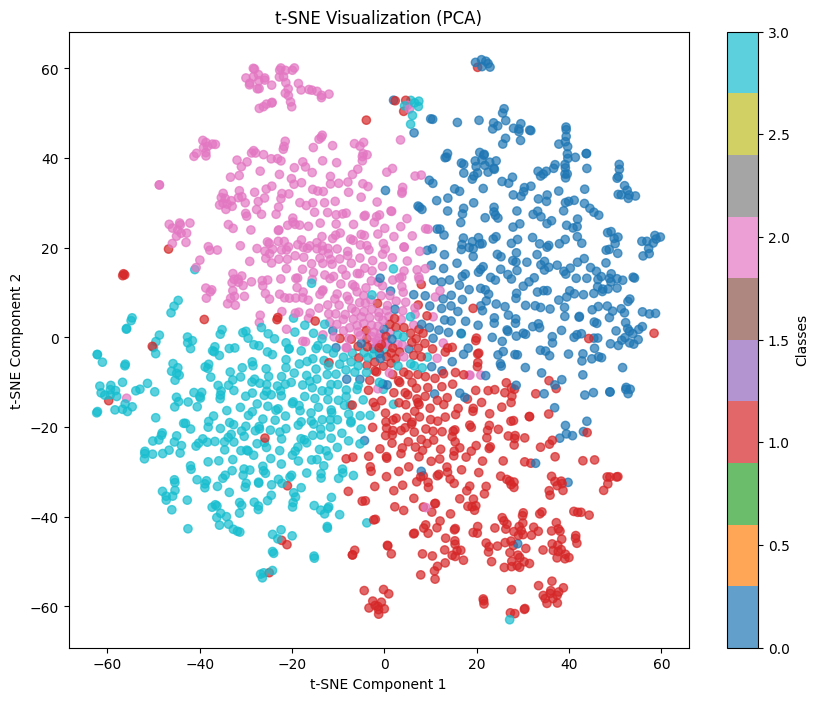

In [72]:
visualize_with_tsne(x_train_vectors_pca, y_train_numeric, "t-SNE Visualization (PCA)")


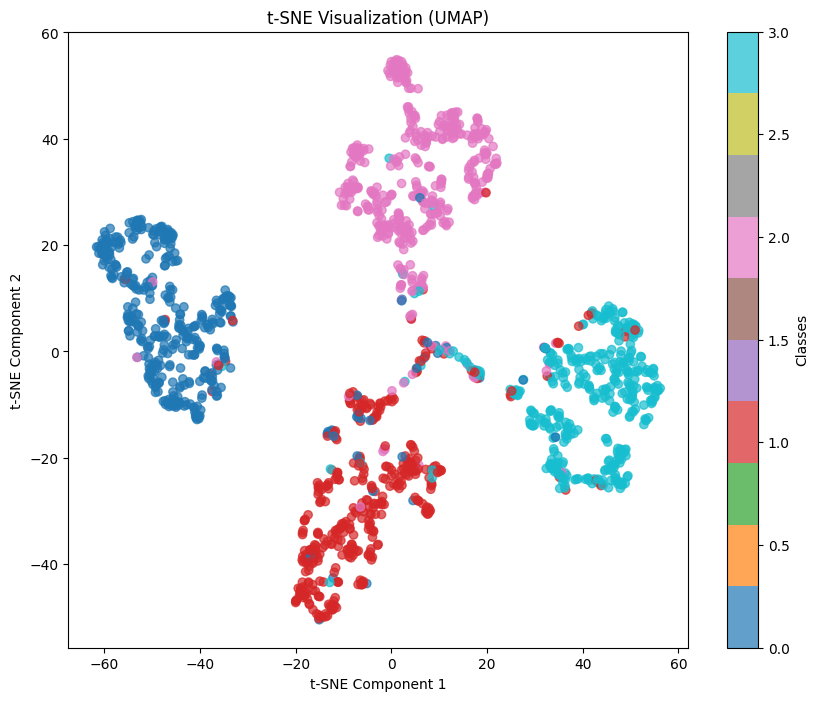

In [74]:
visualize_with_tsne(x_train_vectors, y_train_numeric, "t-SNE Visualization (UMAP)")


In [75]:

def assign_clusters_to_labels(true_labels, predicted_clusters):
    cluster_to_label_mapping = {}
    unique_clusters = np.unique(predicted_clusters)

    for cluster in unique_clusters:
        indices = np.where(predicted_clusters == cluster)[0]
        cluster_labels = true_labels[indices]
        majority_label = np.bincount(cluster_labels).argmax()  # Eticheta majoritară
        cluster_to_label_mapping[cluster] = majority_label

    aligned_labels = np.array([cluster_to_label_mapping[cluster] for cluster in predicted_clusters])

    return aligned_labels, cluster_to_label_mapping


In [76]:
def plot_confusion_matrix_with_class_names(true_labels, aligned_labels, class_mapping):
    class_names = [name for name, _ in sorted(class_mapping.items(), key=lambda x: x[1])]

    cm = confusion_matrix(true_labels, aligned_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels (Clusters)')
    plt.ylabel('True Labels')
    plt.show()


In [77]:
def kmedoids_grid_search_with_logging(data, k_values, distance_metrics):
    results = []
    best_score = -1
    best_params = None
    best_model = None

    for k in k_values:
        for metric in distance_metrics:
            print(f"Testing K={k} with metric={metric}...")
            kmedoids = KMedoids(n_clusters=k, metric=metric, random_state=42)
            labels = kmedoids.fit_predict(data)

            score = silhouette_score(data, labels, metric=metric)
            print(f"Silhouette Score: {score:.4f}")

            results.append({'k': k, 'metric': metric, 'silhouette_score': score})

            if score > best_score:
                best_score = score
                best_params = {'k': k, 'metric': metric}
                best_model = kmedoids

    results_df = pd.DataFrame(results)

    print("\nBest parameters:")
    print(f"K: {best_params['k']}, Metric: {best_params['metric']}, Silhouette Score: {best_score:.4f}")
    return best_model, best_params, best_score, results_df

k_values = [2, 3, 4, 5, 6, 7, 8, 9]
distance_metrics = ['euclidean', 'manhattan', 'cosine']

best_model, best_params, best_score, kmedoids_results_df = kmedoids_grid_search_with_logging(x_train_vectors, k_values, distance_metrics)

kmedoids_results_df


Testing K=2 with metric=euclidean...
Silhouette Score: 0.3493
Testing K=2 with metric=manhattan...
Silhouette Score: 0.2326
Testing K=2 with metric=cosine...
Silhouette Score: 0.5608
Testing K=3 with metric=euclidean...
Silhouette Score: 0.5315
Testing K=3 with metric=manhattan...
Silhouette Score: 0.5354
Testing K=3 with metric=cosine...
Silhouette Score: 0.6271
Testing K=4 with metric=euclidean...
Silhouette Score: 0.6413
Testing K=4 with metric=manhattan...
Silhouette Score: 0.6316
Testing K=4 with metric=cosine...
Silhouette Score: 0.8431
Testing K=5 with metric=euclidean...
Silhouette Score: 0.5433
Testing K=5 with metric=manhattan...
Silhouette Score: 0.5391
Testing K=5 with metric=cosine...
Silhouette Score: 0.7556
Testing K=6 with metric=euclidean...
Silhouette Score: 0.4775
Testing K=6 with metric=manhattan...
Silhouette Score: 0.4696
Testing K=6 with metric=cosine...
Silhouette Score: 0.6509
Testing K=7 with metric=euclidean...
Silhouette Score: 0.3849
Testing K=7 with metric

,k,metric,silhouette_score
0,2,euclidean,0.349297
1,2,manhattan,0.232593
2,2,cosine,0.560804
3,3,euclidean,0.531485
4,3,manhattan,0.535351
5,3,cosine,0.627136
6,4,euclidean,0.641322
7,4,manhattan,0.631552
8,4,cosine,0.843137
9,5,euclidean,0.543284


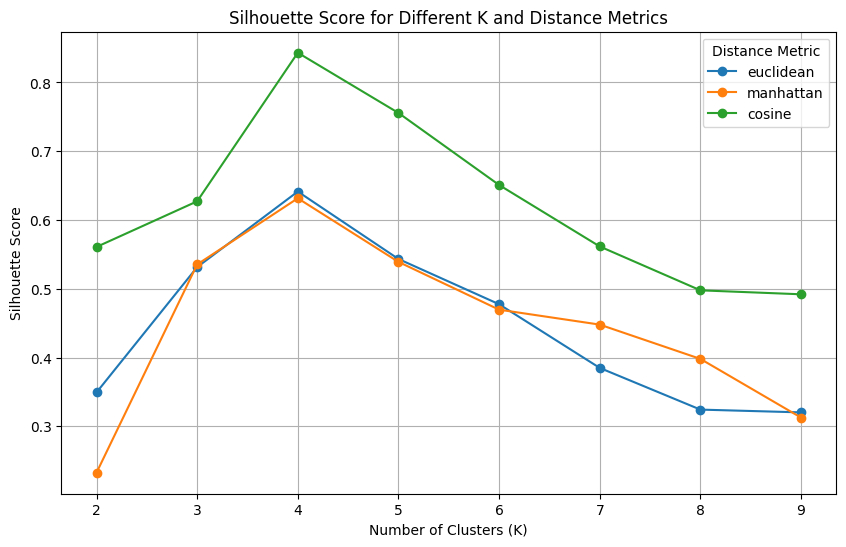

In [78]:
def plot_grid_search_results(results_df):

    plt.figure(figsize=(10, 6))
    for metric in results_df['metric'].unique():
        subset = results_df[results_df['metric'] == metric]
        plt.plot(subset['k'], subset['silhouette_score'], marker='o', label=metric)

    plt.title("Silhouette Score for Different K and Distance Metrics")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.legend(title="Distance Metric")
    plt.grid(True)
    plt.show()

plot_grid_search_results(kmedoids_results_df)


In [80]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

def gmm_grid_search(data, n_components_values, covariance_types):

    results = []
    best_score = -1
    best_params = None
    best_model = None

    for n_components in n_components_values:
        for covariance_type in covariance_types:
            print(f"Testing n_components={n_components} with covariance_type={covariance_type}...")
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm_labels = gmm.fit_predict(data)

            score = silhouette_score(data, gmm_labels, metric='euclidean')
            print(f"Silhouette Score: {score:.4f}")

            results.append({'n_components': n_components, 'covariance_type': covariance_type, 'silhouette_score': score})

            if score > best_score:
                best_score = score
                best_params = {'n_components': n_components, 'covariance_type': covariance_type}
                best_model = gmm

    results_df = pd.DataFrame(results)

    print("\nBest parameters:")
    print(f"n_components: {best_params['n_components']}, Covariance Type: {best_params['covariance_type']}, Silhouette Score: {best_score:.4f}")
    return best_model, best_params, best_score, results_df

n_components_values = [2, 3, 4, 5, 6, 7, 8, 9]
covariance_types = ['full', 'diag', 'spherical']

best_gmm_model, best_gmm_params, best_gmm_score, gmm_results_df = gmm_grid_search(x_train_vectors, n_components_values, covariance_types)

gmm_results_df


Testing n_components=2 with covariance_type=full...
Silhouette Score: 0.4206
Testing n_components=2 with covariance_type=diag...
Silhouette Score: 0.4215
Testing n_components=2 with covariance_type=spherical...
Silhouette Score: 0.4212
Testing n_components=3 with covariance_type=full...
Silhouette Score: 0.4767
Testing n_components=3 with covariance_type=diag...
Silhouette Score: 0.4764
Testing n_components=3 with covariance_type=spherical...
Silhouette Score: 0.4649
Testing n_components=4 with covariance_type=full...
Silhouette Score: 0.6394
Testing n_components=4 with covariance_type=diag...
Silhouette Score: 0.6414
Testing n_components=4 with covariance_type=spherical...
Silhouette Score: 0.6411
Testing n_components=5 with covariance_type=full...
Silhouette Score: 0.5431
Testing n_components=5 with covariance_type=diag...
Silhouette Score: 0.5454
Testing n_components=5 with covariance_type=spherical...
Silhouette Score: 0.5497
Testing n_components=6 with covariance_type=full...
Silh

,n_components,covariance_type,silhouette_score
0,2,full,0.420645
1,2,diag,0.421529
2,2,spherical,0.421231
3,3,full,0.476702
4,3,diag,0.476437
5,3,spherical,0.464856
6,4,full,0.639381
7,4,diag,0.641405
8,4,spherical,0.641068
9,5,full,0.543071


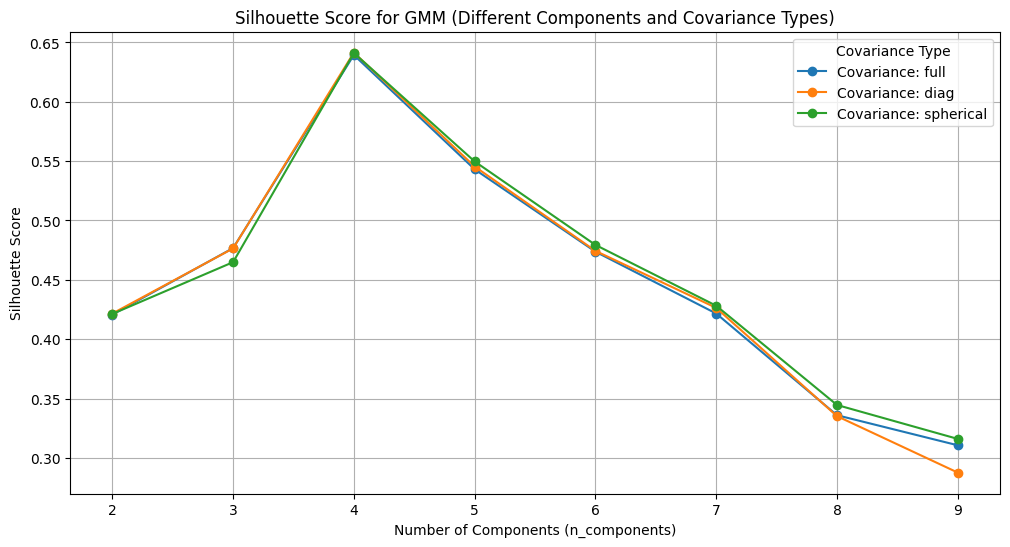

In [81]:
def plot_gmm_grid_search_results(results_df):

    plt.figure(figsize=(12, 6))
    for cov_type in results_df['covariance_type'].unique():
        subset = results_df[results_df['covariance_type'] == cov_type]
        plt.plot(subset['n_components'], subset['silhouette_score'], marker='o', label=f'Covariance: {cov_type}')

    plt.title("Silhouette Score for GMM (Different Components and Covariance Types)")
    plt.xlabel("Number of Components (n_components)")
    plt.ylabel("Silhouette Score")
    plt.legend(title="Covariance Type")
    plt.grid(True)
    plt.show()

plot_gmm_grid_search_results(gmm_results_df)


In [82]:
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

def find_optimal_params(df, method_name):
    best_row = df.loc[df['silhouette_score'].idxmax()]
    print(f"\nBest parameters for {method_name}:")
    print(best_row)
    return best_row


def assign_clusters_to_labels(true_labels, predicted_labels):
    cluster_to_label_mapping = {}
    unique_clusters = np.unique(predicted_labels)

    for cluster in unique_clusters:
        indices = np.where(predicted_labels == cluster)[0]
        cluster_labels = true_labels[indices]
        majority_label = np.bincount(cluster_labels).argmax()
        cluster_to_label_mapping[cluster] = majority_label

    aligned_labels = np.array([cluster_to_label_mapping[label] for label in predicted_labels])
    return aligned_labels, cluster_to_label_mapping


def evaluate_clustering(true_labels, predicted_labels, method_name):
    aligned_labels, cluster_mapping = assign_clusters_to_labels(true_labels, predicted_labels)

    ari = adjusted_rand_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, aligned_labels)
    cm = confusion_matrix(true_labels, aligned_labels)

    print(f"\n{method_name} Evaluation:")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cluster-to-label mapping: {cluster_mapping}")

    return ari, accuracy, cm, cluster_mapping



In [83]:
best_kmedoids_params = find_optimal_params(kmedoids_results_df, "K-Medoids")
best_gmm_params = find_optimal_params(gmm_results_df, "GMM")

kmedoids = KMedoids(n_clusters=int(best_kmedoids_params['k']), metric=best_kmedoids_params['metric'], random_state=42)
kmedoids_labels = kmedoids.fit_predict(x_train_vectors)

ari_kmedoids, acc_kmedoids, cm_kmedoids, kmedoids_mapping = evaluate_clustering(y_train_numeric, kmedoids_labels, "K-Medoids")


gmm = GaussianMixture(
    n_components=int(best_gmm_params['n_components']),
    covariance_type=best_gmm_params['covariance_type'],
    random_state=42
)
gmm_labels = gmm.fit_predict(x_train_vectors)

ari_gmm, acc_gmm, cm_gmm, gmm_mapping = evaluate_clustering(y_train_numeric, gmm_labels, "GMM")




Best parameters for K-Medoids:
k                          4
metric                cosine
silhouette_score    0.843137
Name: 8, dtype: object

Best parameters for GMM:
n_components               4
covariance_type         diag
silhouette_score    0.641405
Name: 7, dtype: object

K-Medoids Evaluation:
Adjusted Rand Index (ARI): 0.8229
Accuracy: 0.9300
Cluster-to-label mapping: {0: 2, 1: 3, 2: 0, 3: 1}

GMM Evaluation:
Adjusted Rand Index (ARI): 0.8244
Accuracy: 0.9306
Cluster-to-label mapping: {0: 1, 1: 0, 2: 3, 3: 2}


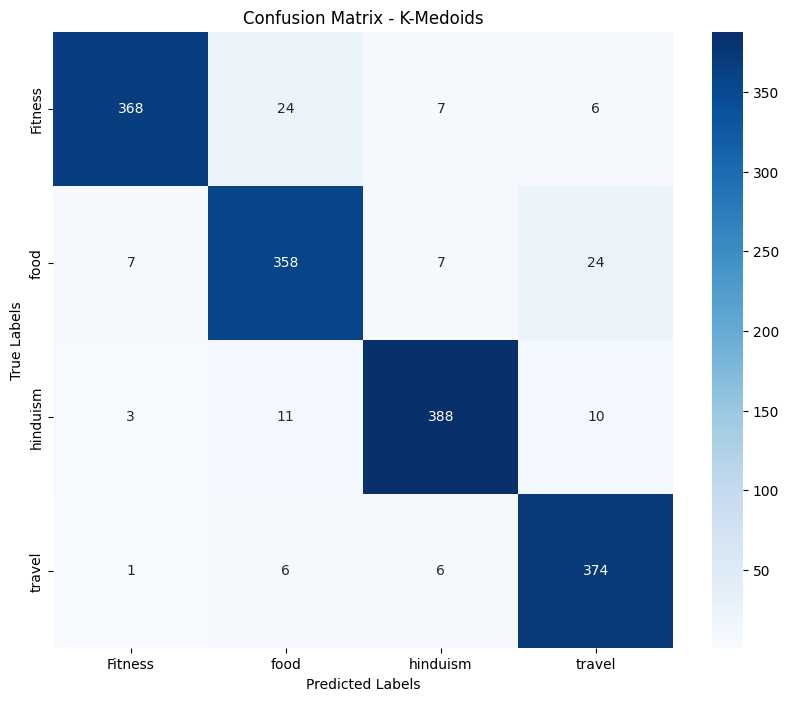

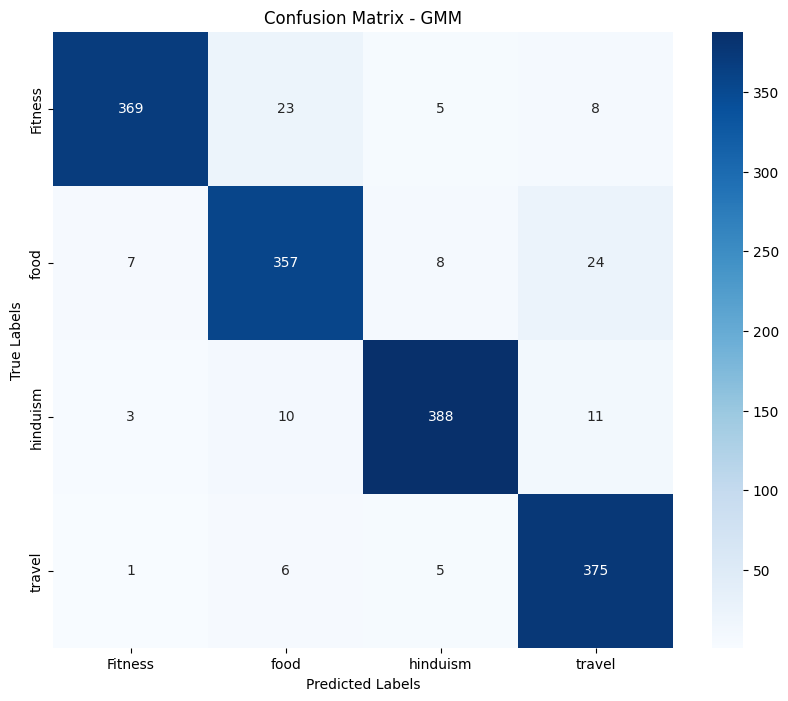

In [84]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

class_names = ['Fitness', 'food', 'hinduism', 'travel']

plot_confusion_matrix(cm_kmedoids, class_names, "Confusion Matrix - K-Medoids")

plot_confusion_matrix(cm_gmm, class_names, "Confusion Matrix - GMM")

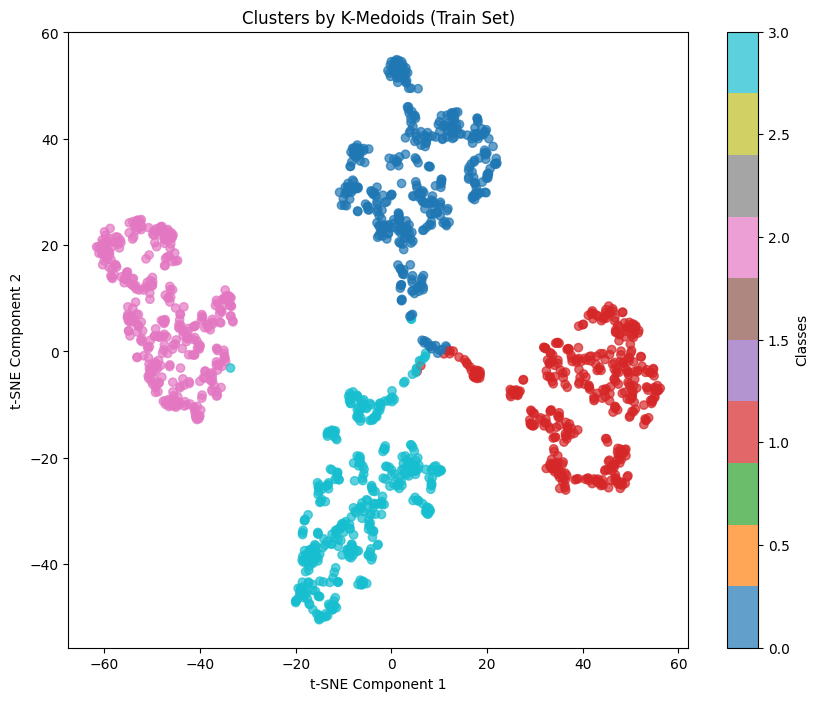

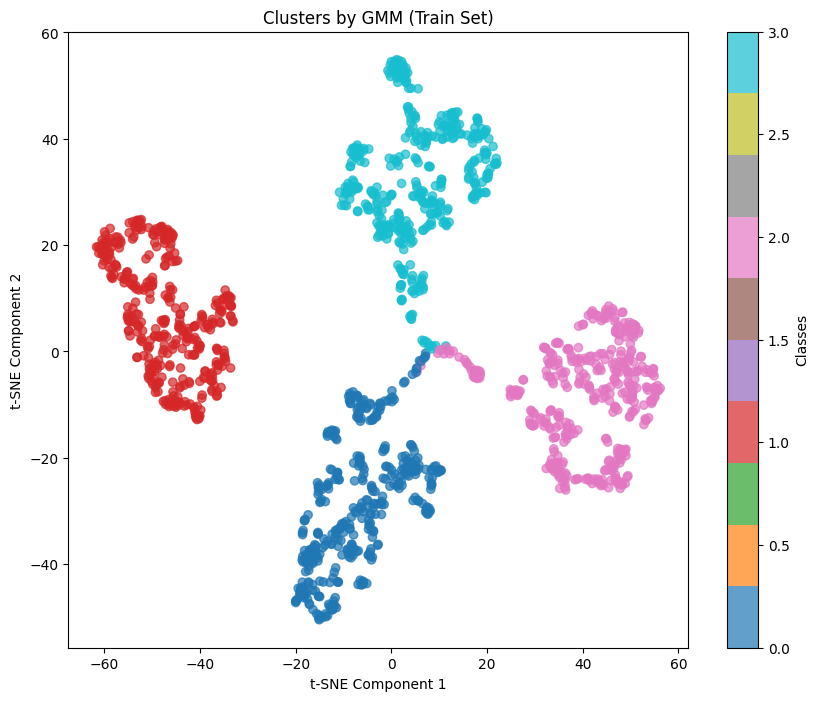

In [85]:
visualize_with_tsne(x_train_vectors, kmedoids_labels, "Clusters by K-Medoids (Train Set)")

visualize_with_tsne(x_train_vectors, gmm_labels, "Clusters by GMM (Train Set)")


# Testare

In [86]:
def evaluate_test_set(model, x_test, y_test, cluster_mapping, method_name):

    predicted_labels = model.predict(x_test)

    aligned_labels = np.array([cluster_mapping[label] for label in predicted_labels])

    ari = adjusted_rand_score(y_test, predicted_labels)
    accuracy = accuracy_score(y_test, aligned_labels)
    cm = confusion_matrix(y_test, aligned_labels)

    print(f"\n{method_name} Evaluation on Test Set:")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return ari, accuracy, cm


In [87]:

kmedoids_test_ari, kmedoids_test_acc, kmedoids_test_cm = evaluate_test_set(
    kmedoids, x_test_vectors, y_test_numeric, cluster_mapping=kmedoids_mapping, method_name="K-Medoids"
)

gmm_test_ari, gmm_test_acc, gmm_test_cm = evaluate_test_set(
    gmm, x_test_vectors, y_test_numeric, cluster_mapping=gmm_mapping, method_name="GMM"
)



K-Medoids Evaluation on Test Set:
Adjusted Rand Index (ARI): 0.8308
Accuracy: 0.9350

GMM Evaluation on Test Set:
Adjusted Rand Index (ARI): 0.8302
Accuracy: 0.9350


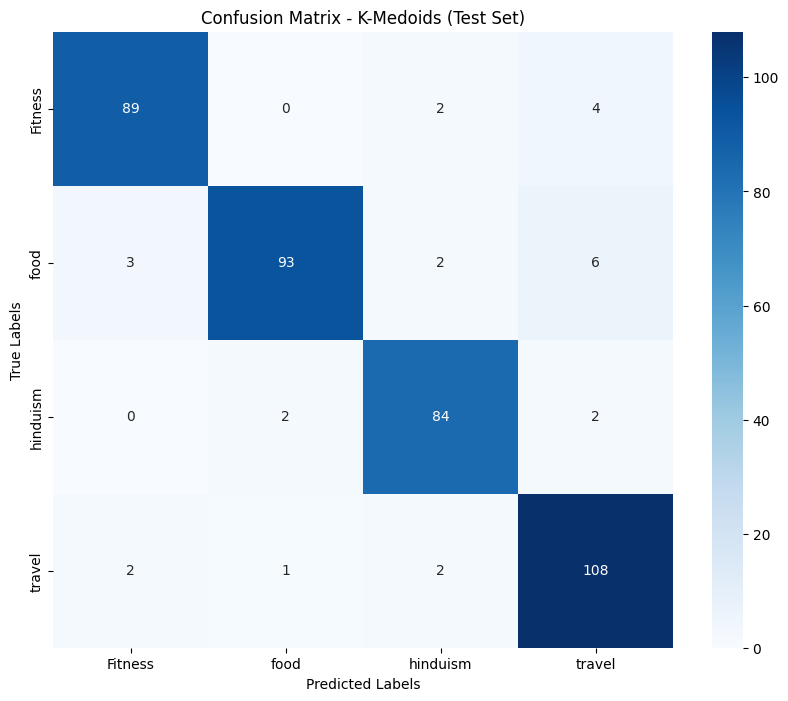

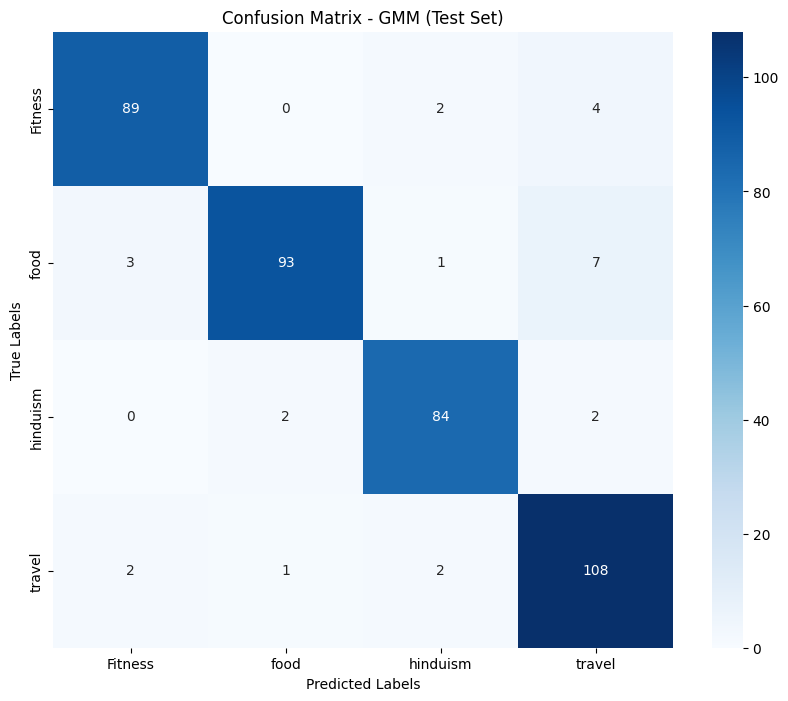

In [88]:
plot_confusion_matrix(kmedoids_test_cm, class_names, "Confusion Matrix - K-Medoids (Test Set)")
plot_confusion_matrix(gmm_test_cm, class_names, "Confusion Matrix - GMM (Test Set)")


# Clasificare

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate_knn(x_train, y_train, x_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    knn_predictions = knn.predict(x_test)
    accuracy = accuracy_score(y_test, knn_predictions)
    print(f"KNN Accuracy (k={n_neighbors}): {accuracy:.4f}")
    return accuracy

def evaluate_random_choice(y_test, num_classes):
    random_predictions = np.random.choice(np.arange(num_classes), size=len(y_test))
    accuracy = accuracy_score(y_test, random_predictions)
    print(f"Random Choice Accuracy: {accuracy:.4f}")
    return accuracy


knn_accuracy = evaluate_knn(x_train_vectors, y_train_numeric, x_test_vectors, y_test_numeric)

num_classes = len(np.unique(y_train_numeric))
random_accuracy = evaluate_random_choice(y_test_numeric, num_classes)


KNN Accuracy (k=5): 0.9450
Random Choice Accuracy: 0.2450


# A treia metoda

In [90]:
from sklearn.cluster import KMeans

def kmeans_grid_search(data, k_values):
    results = []
    best_score = -1
    best_model = None
    best_k = None

    for k in k_values:
        print(f"Testing K={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)

        score = silhouette_score(data, kmeans_labels, metric='euclidean')
        print(f"Silhouette Score: {score:.4f}")

        results.append({'k': k, 'silhouette_score': score})

        if score > best_score:
            best_score = score
            best_model = kmeans
            best_k = k

    results_df = pd.DataFrame(results)
    print(f"\nBest K: {best_k}, Silhouette Score: {best_score:.4f}")
    return best_model, best_k, best_score, results_df

k_values = [2, 3, 4, 5, 6, 7, 8, 9]

best_kmeans_model, best_k, best_kmeans_score, kmeans_results_df = kmeans_grid_search(x_train_vectors, k_values)


Testing K=2...
Silhouette Score: 0.4192
Testing K=3...
Silhouette Score: 0.4782
Testing K=4...
Silhouette Score: 0.6418
Testing K=5...
Silhouette Score: 0.5477
Testing K=6...
Silhouette Score: 0.4799
Testing K=7...
Silhouette Score: 0.4293
Testing K=8...
Silhouette Score: 0.3463
Testing K=9...
Silhouette Score: 0.3191

Best K: 4, Silhouette Score: 0.6418



K-Means Evaluation:
Adjusted Rand Index (ARI): 0.8157
Accuracy: 0.9269
Cluster-to-label mapping: {0: 1, 1: 0, 2: 3, 3: 2}


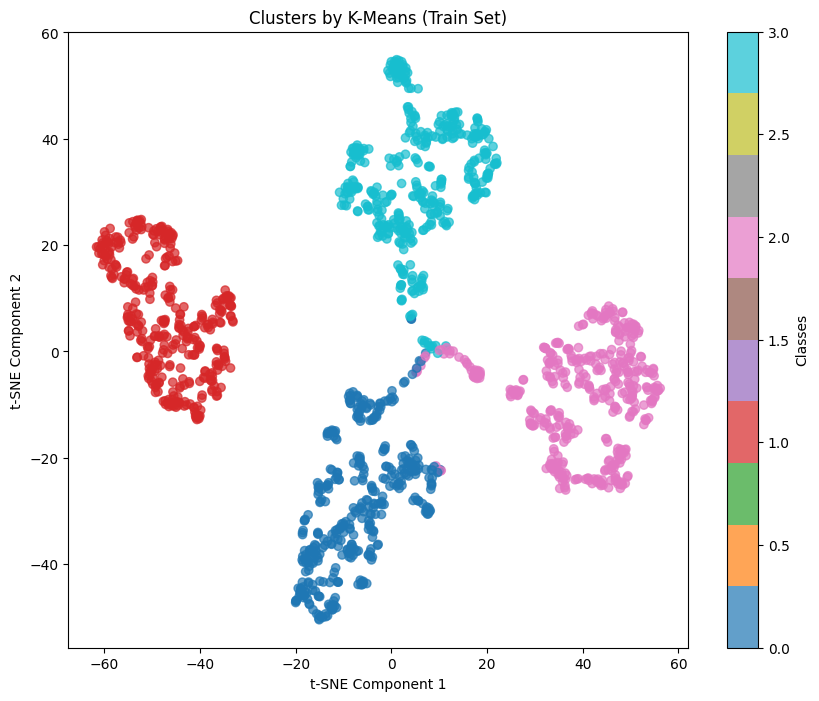

In [91]:
kmeans_labels = best_kmeans_model.labels_

ari_kmeans, acc_kmeans, cm_kmeans, kmeans_mapping = evaluate_clustering(y_train_numeric, kmeans_labels, "K-Means")

visualize_with_tsne(x_train_vectors, kmeans_labels, "Clusters by K-Means (Train Set)")


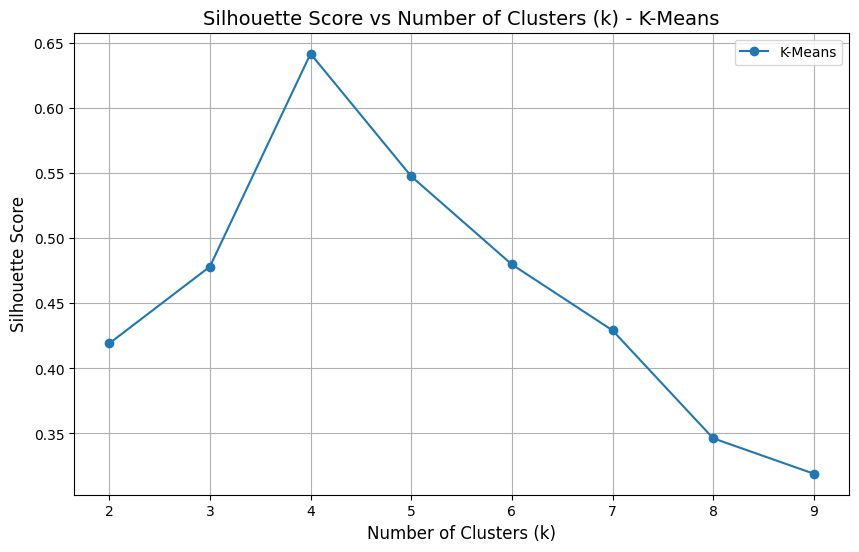

In [92]:
def plot_silhouette_scores(results_df, method_name):
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['k'], results_df['silhouette_score'], marker='o', linestyle='-', label=method_name)
    plt.title(f"Silhouette Score vs Number of Clusters (k) - {method_name}", fontsize=14)
    plt.xlabel("Number of Clusters (k)", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.xticks(results_df['k'])
    plt.grid(True)
    plt.legend()
    plt.show()

plot_silhouette_scores(kmeans_results_df, "K-Means")



K-Means Evaluation on Test Set:
Adjusted Rand Index (ARI): 0.8302
Accuracy: 0.9350


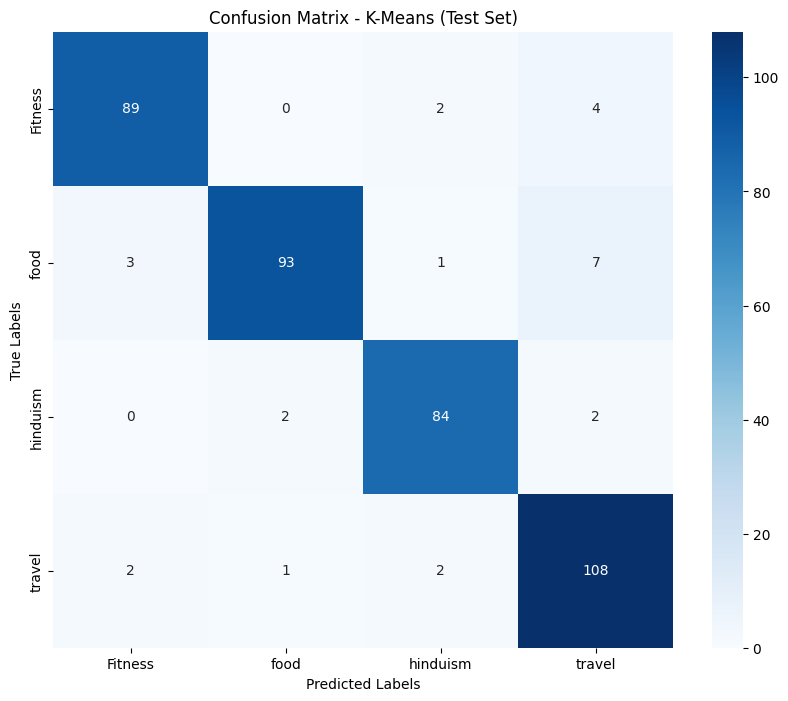

In [93]:
kmeans_test_labels = best_kmeans_model.predict(x_test_vectors)

kmeans_test_ari, kmeans_test_acc, kmeans_test_cm = evaluate_test_set(
    best_kmeans_model, x_test_vectors, y_test_numeric, cluster_mapping=kmeans_mapping, method_name="K-Means"
)

plot_confusion_matrix(kmeans_test_cm, class_names, "Confusion Matrix - K-Means (Test Set)")


In [95]:
print()